# Stacking Example
#### <font color="blue"> by: Jeremy Meinke

This notebook will outline the various maps and stacking code that I've built
(and now cleaned up for you).  

The goal of everything here is to:
1.  Show a good summary of my work conducted.
2.  Provide others (future grad students or general astrophysics audience) with code that can be the foundation for even cooler analysis!

---


To start with, we'll load up the SPT-SZ Cluster Catalog.  For convenience, you can use the shell scripts in ./data/ to download any files I'll show here.  

In ./data/ terminal, run "bash pull_spt_cluster_catalog_2019_wget.sh"

Done? Okay:

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from astropy.table import Table
import healpy as hp
import matplotlib.pyplot as plt
import time
import gc  
###SPT maps are big... gc.collect() is a safety way to try to keep the notebook from using too much memory

from stacking_code import stacking    ###My stacking code
from analysis_code import general     ###My general analysis code

print("Last time run: %s"%time.asctime())


Last time run: Fri Jan 27 13:06:44 2023


Now reading the cluster catalog and into a pandas table:

In [2]:
catalog = Table.read("./data/2500d_cluster_sample_Bocquet19.fits", format="fits").to_pandas()
print("Table Columns: \n", list(catalog.columns))
print("\nCatalog size: ", len(catalog))
# print(catalog)    ###To view what each column looks like

Table Columns: 
 ['SPT_ID', 'RA', 'DEC', 'FIELD', 'XI', 'THETA_CORE', 'YSZ', 'DYSZ', 'REDSHIFT', 'REDSHIFT_UNC', 'REDSHIFT_LIMIT', 'XRAY', 'SPECZ', 'WEAK_LENSING', 'M500', 'M500_uerr', 'M500_lerr', 'M200', 'M200_uerr', 'M200_lerr', 'M500_marge', 'M500_marge_uerr', 'M500_marge_lerr', 'M200_marge', 'M200_marge_uerr', 'M200_marge_lerr']

Catalog size:  677


Now selecting the RAs and DECs of our catalog

In [3]:
catalog_ra = catalog["RA"]
catalog_dec = catalog["DEC"]

### Next Step: Load Map (SPT 95 GHz)
##### *Note*: 
My healpix map loading code by default, i.e. calling stacking.map_data_healpix_fits(file_name), uses healpy.read_map() as the default.  *However* I've noticed loading the SPT-SZ maps, which are ~3 GB, for some reason uses all 16GB of my memory...  likely something to do with either the .fits file header or healpy.read_map() function.

This memory issue can be avoided by calling stacking.map_data_healpix_fits(file_name, unreadable_header = True), as I have "unreadable_header = True" instead use astropy.io.fits.open(file_name).  The other option is to use alm files if provided, i.e. stacking.map_data_healpix_fits(file_name, healpix_alm = True)

***

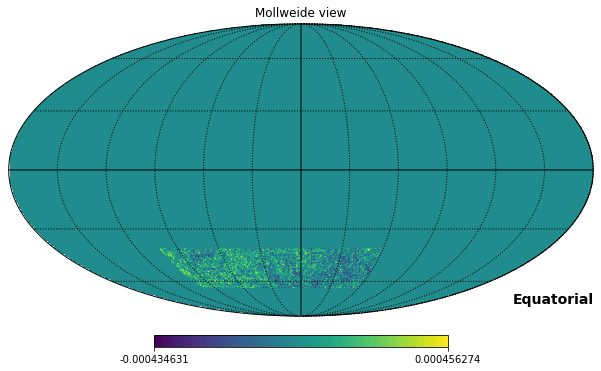

In [4]:
spt_map = stacking.map_data_healpix_fits("./data/combined_map_95GHz_nside8192_ptsrcmasked_50mJy.fits", unreadable_header = True)

hp.mollview(spt_map, coord = "C")    ###Coord = "C" just tells it the map is celestial/equatorial (puts label on plot)
hp.graticule()
plt.show()


In [5]:
# print(hp.ang2pix(8192, np.deg2rad(90 - catalog_dec[:2].to_numpy()), np.deg2rad(catalog_ra[:2].to_numpy())))
# print(spt_map[hp.ang2pix(8192, np.deg2rad(90 - catalog_dec[:2].to_numpy()), np.deg2rad(catalog_ra[:2].to_numpy()))])

# spt_map[hp.ang2pix(8192, np.deg2rad(90 - catalog_dec[:0].to_numpy()), np.deg2rad(catalog_ra[:0].to_numpy()))] = -200

# print(spt_map[hp.ang2pix(8192, np.deg2rad(90 - catalog_dec[:2].to_numpy()), np.deg2rad(catalog_ra[:2].to_numpy()))])
###Checking stacking by zeroing the catalog pixels
# spt_map[hp.ang2pix(8192, np.deg2rad(90 - catalog_dec.to_numpy()), np.deg2rad(catalog_ra.to_numpy()))] = 0

Now we want to do some stacking of the cluster catalog:

In [6]:
###With interpolation
spt_95_interp = stacking.stack(spt_map, catalog_ra.to_numpy(), catalog_dec.to_numpy(), 15, .1, interpolate = True)
###Note: you technically don't really need the .to_numpy() here, but only because the pandas table has default row numbering

Start Time:  Fri Jan 27 13:06:47 2023
Catalog length: 677
Post-Stack Time:  Fri Jan 27 13:06:52 2023


array([[0.02291076, 0.02287788, 0.02282171, ..., 0.02031052, 0.02035027,
        0.02040412],
       [0.02286194, 0.02283435, 0.02279656, ..., 0.02020036, 0.02022433,
        0.02027   ],
       [0.02285429, 0.02283308, 0.02281636, ..., 0.0201039 , 0.02011548,
        0.02015038],
       ...,
       [0.02029313, 0.02033291, 0.02038389, ..., 0.01912389, 0.01904308,
        0.01895531],
       [0.02041248, 0.0204213 , 0.02044656, ..., 0.0192709 , 0.01921265,
        0.01913697],
       [0.02050814, 0.02048887, 0.02048484, ..., 0.01942996, 0.0193828 ,
        0.01931626]])

In [7]:
###And without interpolation: (less noticeable with the larger the sample)
spt_95 = stacking.stack(spt_map, catalog_ra.to_numpy(), catalog_dec.to_numpy(), 15, .1, interpolate = False)

Start Time:  Fri Jan 27 13:06:52 2023
Catalog length: 677
Post-Stack Time:  Fri Jan 27 13:06:54 2023


array([[0.02304399, 0.0227264 , 0.02255747, ..., 0.0204718 , 0.02059292,
        0.02074848],
       [0.02276595, 0.0226935 , 0.02276504, ..., 0.02010022, 0.0206731 ,
        0.02076377],
       [0.02268696, 0.02276001, 0.02279925, ..., 0.02028829, 0.02047669,
        0.02034388],
       ...,
       [0.02024999, 0.02017776, 0.02021103, ..., 0.01937791, 0.01924275,
        0.01884997],
       [0.02038747, 0.02037073, 0.02056511, ..., 0.0193995 , 0.01955509,
        0.01914441],
       [0.02055006, 0.02078211, 0.02037927, ..., 0.01950737, 0.01961962,
        0.01935276]])

### Radial Profile

Now, before we look at the other frequencies, let's "stack" the radial profiles into a table as well: